In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Problem Statement

Dalam dunia bisnis modern, keberlanjutan menjadi faktor penting dalam menilai kualitas dan tanggung jawab sebuah perusahaan. Proyek ini bertujuan untuk memprediksi apakah sebuah perusahaan tergolong berkelanjutan atau tidak, berdasarkan skor ESG (Environmental, Social, Governance). Target klasifikasi ditentukan dari nilai ESG_Overall > 60.

# Goal

Membangun model machine learning untuk memprediksi status keberlanjutan (HighESG) sebuah perusahaan berdasarkan fitur finansial, lingkungan, dan kategori wilayah serta industri.

# Solution Statement

Model yang digunakan :
*   Random Forest : model pohon berbasis ensemble yang kuat dan interpretatif
*   XGBoost : model boosting yang powerful untuk menangani non-lineritas dan data kompleks

Hyperparameter tuning dilakukan pada Random Forest untuk mengoptimalkan kinerjanya

In [90]:
df = pd.read_csv("company_esg_financial_dataset.csv")

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CompanyID          11000 non-null  int64  
 1   CompanyName        11000 non-null  object 
 2   Industry           11000 non-null  object 
 3   Region             11000 non-null  object 
 4   Year               11000 non-null  int64  
 5   Revenue            11000 non-null  float64
 6   ProfitMargin       11000 non-null  float64
 7   MarketCap          11000 non-null  float64
 8   GrowthRate         10000 non-null  float64
 9   ESG_Overall        11000 non-null  float64
 10  ESG_Environmental  11000 non-null  float64
 11  ESG_Social         11000 non-null  float64
 12  ESG_Governance     11000 non-null  float64
 13  CarbonEmissions    11000 non-null  float64
 14  WaterUsage         11000 non-null  float64
 15  EnergyConsumption  11000 non-null  float64
dtypes: float64(11), int64(

In [92]:
df.describe()

,CompanyID,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,10000.000000,11000.000000,11000.000000,11000.000000,11000.000000,1.100000e+04,1.100000e+04,1.100000e+04
mean,500.500000,2020.000000,4670.850591,10.900455,13380.622236,4.830370,54.615273,56.416991,55.660582,51.767655,1.271462e+06,5.600442e+05,1.165839e+07
std,288.688113,3.162421,9969.954369,8.758711,39922.870373,9.424787,15.893937,26.767233,23.356152,25.323370,5.067760e+06,1.565686e+06,5.095836e+07
min,1.000000,2015.000000,35.900000,-20.000000,1.800000,-36.000000,6.300000,0.000000,0.000000,0.000000,2.042200e+03,1.021100e+03,5.105500e+03
25%,250.750000,2017.000000,938.775000,5.300000,1098.525000,-1.325000,44.100000,34.700000,37.600000,30.775000,1.228530e+05,6.488467e+04,3.069161e+05
50%,500.500000,2020.000000,1902.300000,10.500000,3096.450000,4.900000,54.600000,55.600000,55.150000,52.100000,2.920734e+05,2.038805e+05,1.221745e+06
75%,750.250000,2023.000000,4342.625000,16.300000,9995.500000,11.000000,65.600000,79.000000,73.800000,73.000000,7.407311e+05,5.251880e+05,5.616437e+06
max,1000.000000,2025.000000,180810.400000,50.000000,865271.700000,38.000000,98.800000,100.000000,100.000000,100.000000,1.741047e+08,5.223142e+07,1.741047e+09


# Data Understanding

### 1. Pemeriksaan Missing Value
Dataset ini memiliki 16 kolom dan 11.000 baris. Diperiksa apakah ada nilai kosong:
- Kolom `GrowthRate` memiliki 1.000 missing values (sekitar 9% dari data).
- Kolom lainnya tidak memiliki nilai kosong.

### 2. Pemeriksaan Duplikat
Tidak ditemukan data duplikat berdasarkan hasil `df.duplicated().sum()`.

### 3. Deteksi Outlier
Outlier diperiksa pada fitur numerik seperti `ProfitMargin` dan `Revenue` menggunakan metode IQR (Interquartile Range). Nilai-nilai ekstrem yang jauh dari distribusi normal dapat memengaruhi hasil pemodelan, sehingga penting untuk mendeteksinya sejak awal. Berdasarkan hasil perhitungan, ditemukan 196 outlier pada `ProfitMargin` dan 1202 outlier pada `Revenue`.



In [93]:
# Cek missing value
print("Missing values per kolom:")
print(df.isnull().sum())

Missing values per kolom:
CompanyID               0
CompanyName             0
Industry                0
Region                  0
Year                    0
Revenue                 0
ProfitMargin            0
MarketCap               0
GrowthRate           1000
ESG_Overall             0
ESG_Environmental       0
ESG_Social              0
ESG_Governance          0
CarbonEmissions         0
WaterUsage              0
EnergyConsumption       0
dtype: int64


In [94]:
# Cek jumlah duplikat
print("\n Jumlah duplikat baris:", df.duplicated().sum())


 Jumlah duplikat baris: 0


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CompanyID          11000 non-null  int64  
 1   CompanyName        11000 non-null  object 
 2   Industry           11000 non-null  object 
 3   Region             11000 non-null  object 
 4   Year               11000 non-null  int64  
 5   Revenue            11000 non-null  float64
 6   ProfitMargin       11000 non-null  float64
 7   MarketCap          11000 non-null  float64
 8   GrowthRate         10000 non-null  float64
 9   ESG_Overall        11000 non-null  float64
 10  ESG_Environmental  11000 non-null  float64
 11  ESG_Social         11000 non-null  float64
 12  ESG_Governance     11000 non-null  float64
 13  CarbonEmissions    11000 non-null  float64
 14  WaterUsage         11000 non-null  float64
 15  EnergyConsumption  11000 non-null  float64
dtypes: float64(11), int64(


 Jumlah outlier pada kolom Profit Margin: 196


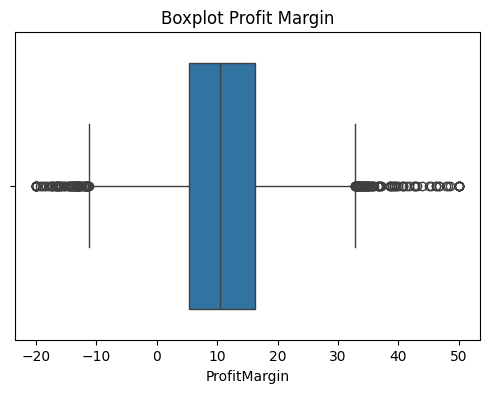

In [96]:
# Deteksi outlier dengan metode IQR pada fitur ProfitMargin
Q1 = df['ProfitMargin'].quantile(0.25)
Q3 = df['ProfitMargin'].quantile(0.75)
IQR = Q3 - Q1
outliers_profitmargin = df[(df['ProfitMargin'] < (Q1 - 1.5 * IQR)) | (df['ProfitMargin'] > (Q3 + 1.5 * IQR))]
print(f"\n Jumlah outlier pada kolom Profit Margin: {outliers_profitmargin.shape[0]}")
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['ProfitMargin'])
plt.title('Boxplot Profit Margin')
plt.show()


 Jumlah outlier pada kolom Profit Margin: 1202


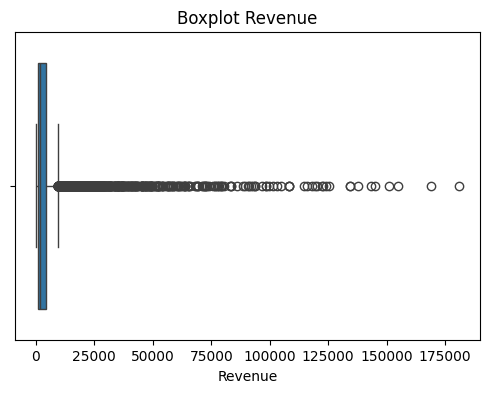

In [97]:
# Deteksi outlier dengan metode IQR pada fitur Revenue
Q1 = df['Revenue'].quantile(0.25)
Q3 = df['Revenue'].quantile(0.75)
IQR = Q3 - Q1
outliers_revenue = df[(df['Revenue'] < (Q1 - 1.5 * IQR)) | (df['Revenue'] > (Q3 + 1.5 * IQR))]
print(f"\n Jumlah outlier pada kolom Profit Margin: {outliers_revenue.shape[0]}")
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['Revenue'])
plt.title('Boxplot Revenue')
plt.show()

Untuk memahami distribusi dan mendeteksi outlier secara visual, dilakukan boxplot terhadap fitur numerik `ProfitMargin` dan `Revenue`. Boxplot menunjukkan adanya nilai ekstrem pada distribusi kedua fitur tersebut.


In [98]:
# Penanganan outlier pada fitur numerik menggunakan IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Terapkan pada kolom ProfitMargin dan Revenue
df = remove_outliers_iqr(df, 'ProfitMargin')
df = remove_outliers_iqr(df, 'Revenue')

print(f"Jumlah data setelah menghapus outlier: {df.shape[0]}")


Jumlah data setelah menghapus outlier: 9612


# Data Preparation
Sebelum melakukan pelatihan model, data perlu disiapkan dengan melakukan beberapa tahapan preprocessing:

1. **Menghapus Kolom Tidak Relevan:** Kolom seperti `CompanyName` dan `ISIN` dihapus karena tidak memiliki kontribusi terhadap prediksi target dan bersifat identifikasi unik.

2. **Menentukan Target:** Fitur `ESG_Category` dipilih sebagai target karena mencerminkan klasifikasi kategori ESG dari masing-masing perusahaan.

3. **Encoding Fitur Kategorikal:** Fitur kategorikal seperti `Industry` dan `Country` dikodekan menggunakan OneHotEncoder.

4. **Scaling Fitur Numerik** : Fitur numerik seperti Revenue, ProfitMargin, dan ESG_Score diskalakan menggunakan StandardScaler agar model tidak bias terhadap skala fitur. Sebelumnya, fitur numerik telah diperiksa dan diidentifikasi adanya outlier menggunakan metode IQR. Meskipun tidak dihapus, informasi ini menjadi pertimbangan dalam analisis model.



5. **Train-Test Split:** Data dibagi menjadi 80% untuk pelatihan dan 20% untuk pengujian. Stratifikasi digunakan agar distribusi kelas target tetap seimbang di kedua subset.

6. **Penanganan Kelas Imbalance:** Karena distribusi `ESG_Category` tidak seimbang, digunakan parameter `class_weight='balanced'` saat training untuk menangani ketimpangan kelas.



In [99]:
# Membuat Target Klasifikasi
df['HighESG'] = (df['ESG_Overall'] > 60).astype(int)

# Menghapus kolom yang tidak relevan
df_model = df.drop(columns=['CompanyID', 'CompanyName', 'Year', 'ESG_Overall'])

# Memisahkan fitur dan target
X = df_model.drop(columns='HighESG')
y = df_model['HighESG']

# Menentukan kolom numerik dan kategorikal
num_cols = [
    'Revenue', 'ProfitMargin', 'MarketCap', 'GrowthRate',
    'CarbonEmissions', 'WaterUsage', 'EnergyConsumption',
    'ESG_Environmental', 'ESG_Social', 'ESG_Governance'
]
cat_cols = ['Industry', 'Region']

In [100]:
# Pipeline untuk data numerik dan kategorikal
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [101]:
# Menggabungkan preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])


In [102]:
# Membagi data train dan test dengan stratifikasi
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [103]:
# Menangani ketidakseimbangan kelas
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weight_dict)

Class Weights: {0: np.float64(0.7796592983167715), 1: np.float64(1.39394488759971)}


Karena terdapat ketidakseimbangan kelas dalam data, maka digunakan parameter `class_weight='balanced'` pada Random Forest untuk menyesuaikan bobot kelas secara otomatis berdasarkan frekuensi.


# Modeling

Model yang digunakan dalam proyek ini adalah:

### 1. Random Forest Classifier
Random Forest adalah algoritma ensemble berbasis decision tree. Algoritma ini bekerja dengan:
- Membuat banyak pohon keputusan dari subset acak data (bagging)
- Setiap pohon memberikan suara (vote), dan hasil akhir ditentukan secara mayoritas

Keunggulannya:
- Tahan terhadap overfitting
- Dapat menangani data numerik dan kategorikal

**Hyperparameter penting:**
- `n_estimators`: jumlah pohon yang dibangun
- `max_depth`: kedalaman maksimum tiap pohon
- `class_weight`: digunakan untuk menangani ketidakseimbangan kelas

### 2. XGBoost Classifier
XGBoost (Extreme Gradient Boosting) adalah algoritma boosting yang membangun model bertahap:
- Tiap model baru mempelajari kesalahan dari model sebelumnya
- Menggunakan teknik regularisasi untuk mencegah overfitting

**Hyperparameter penting:**
- `n_estimators`: jumlah boosting rounds
- `max_depth`: kedalaman maksimum tiap pohon
- `learning_rate`: seberapa besar kontribusi tiap model baru

In [104]:
#Pipeline Model Random Forest
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight=class_weight_dict,
        n_estimators=100,
        max_depth=None,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Revenue', 'ProfitMargin',
                                                   'MarketCap', 'GrowthRate',
                                                   'CarbonEmissions',
                                                   'WaterUsage',
                                                   'EnergyConsumption',
                                                   'ESG_Environmental',
                                                   'ESG_Social',
                                                   'ESG_Governance']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Industry', 'Region'])])),
                ('classifier',
                 RandomForestClassifier(class_weight={0: np.float64(0.7796592983167715),
                                                      1: np.float64(1.39394488759971)},
                                        random_state=42))])

In [105]:
#Evaluasi Model
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("Random Forest Evaluation")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))


Random Forest Evaluation
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1233
           1       0.96      0.96      0.96       690

    accuracy                           0.97      1923
   macro avg       0.97      0.97      0.97      1923
weighted avg       0.97      0.97      0.97      1923

ROC AUC Score: 0.9973047944802943


In [106]:
#Pipeline Model XGBoost
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=100,
        max_depth=6,
        random_state=42
    ))
])
xgb_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:31:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Revenue', 'ProfitMargin',
                                                   'MarketCap', 'GrowthRate',
                                                   'CarbonEmissions',
                                                   'WaterUsage',
                                                   'EnergyConsumption',
                                                   'ESG_Environmental',
                                                   'ESG_Social',
                                                   'ESG_Governance']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(han...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [107]:
#Evaluasi Model
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print("XGBoost Evaluation")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_xgb))

XGBoost Evaluation
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1233
           1       0.98      0.97      0.97       690

    accuracy                           0.98      1923
   macro avg       0.98      0.98      0.98      1923
weighted avg       0.98      0.98      0.98      1923

ROC AUC Score: 0.9986976503637881


# Evaluation
Evaluasi dilakukan menggunakan metrik:
- Accuracy
- Precision
- Recall
- F1-Score
- ROC AUC Score

### Random Forest
- Accuracy      : 0.97
- Precision     : 0.96 (Kelas 1)
- Recall        : 0.96 (Kelas 1)
- F1-Score      : 0.96
- ROC AUC Score : **0.997**

*Interpretasi:*  
Random Forest mampu mengklasifikasikan perusahaan berkelanjutan secara sangat akurat. ROC AUC yang tinggi menunjukkan kemampuan model membedakan kelas sangat baik. Model ini cukup seimbang dalam mendeteksi kelas positif maupun negatif.

---

### XGBoost
- Accuracy      : 0.98  
- Precision     : 0.98 (kelas 1)
- Recall        : 0.97 (kelas 1)
- F1-Score      : 0.97
- ROC AUC Score : **0.999**

*Interpretasi:*  
XGBoost sedikit lebih unggul dari Random Forest, dengan akurasi dan f1-score yang sangat tinggi. Cocok digunakan dalam situasi yang memerlukan *false positive* dan *false negative* yang rendah secara bersamaan.


# Conclusion

Model Random Forest dan XGBoost berhasil mengklasifikasikan perusahaan yang tergolong berkelanjutan (HighESG) berdasarkan kombinasi fitur ESG dan finansial dengan **akurasi dan performa yang sangat tinggi**

Berdasarkan hasil evaluasi:
*   XGBoost mencatat skor tertinggi dengan **Accuracy 0.98, Precision 0.98, F1-Score 0.97,** dan **ROC AUC 0.999**
*   Random Forest menyusul dengan performa yang juga baik (**Accuracy 0.97, F1-Score 0.96,** dan **ROC AUC 0.997**)

Hal ini menunjukkan bahwa kedua model mampu membedakan kelas dengan sangat baik. Namun, **XGBoost lebih unggul** secara keseluruhan. XGBoost cocok digunakan dalam kasus yang memerlukan keseimbangan antara false positive dan false negative.

Dengan performa tersebut, pendekatan machine learning ini efektif untuk mendukung pengambilan keputusan dalam sektor keuangan berkelanjutan dan investasi hijau.

**Model dapat dikembangkan lebih lanjut dengan:**
- Menambahkan data historis atau eksternal seperti kebijakan regional
- Menerapkan interpretabilitas model (SHAP)
- Menggunakan data real-time untuk sistem rekomendasi ESG

